In [28]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

# Machine Learning
import sklearn.metrics as metrics

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download('punkt')

from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.corpus import stopwords

from IPython.display import display

%pip install svgling
%pip install datasets

pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
from datasets import load_dataset

babe_dataset = load_dataset("mediabiasgroup/BABE-v3")


In [31]:
# convert to df
babe_df = pd.DataFrame(babe_dataset['train'])
babe_df_cleaned = babe_df[['text', 'topic']]

babe_df_cleaned.loc[:, 'topic'] = babe_df_cleaned.loc[:, 'topic'].apply(lambda
                                                     x: " ".join(x.split("-")))

# print number of unique topics
print("Number of unique topics:", len(babe_df_cleaned['topic'].unique()))

babe_df_cleaned.head()

Number of unique topics: 22


,text,topic
0,But instead of closing loopholes that allow cr...,gun control
1,"""You think I'm joking,"" he continued. """,blm
2,"Yes, the rich are rich and want to stay that w...",taxes
3,Americans are carrying $1.57 trillion in outst...,student debt
4,Republican state legislators from Texas to Ari...,gun control


# Q1

In [32]:
def make_tokens(df: pd.DataFrame) -> pd.DataFrame:
  ## Your code starts here ##

  #tokenizing the 'text' col and saving them in a new 'tokens' col
  df['tokens'] = df['text'].apply(lambda x: word_tokenize(x.lower()))

  ## end ##
  return df

In [33]:
babe_df_cleaned = make_tokens(babe_df_cleaned)
print(babe_df_cleaned.loc[0, 'tokens'])

['but', 'instead', 'of', 'closing', 'loopholes', 'that', 'allow', 'criminals', 'to', 'access', 'firearms', ',', 'the', 'bill', 'by', 'house', 'democrats', 'could', 'turn', 'millions', 'of', 'law-abiding', 'american', 'gun', 'owners', 'into', 'felons', '.']


# Q2

In [34]:
def clean_tokens(df: pd.DataFrame) -> pd.DataFrame:
  ## Your code starts here ##
  import string
  stop_words = set(stopwords.words('english') + list(string.punctuation))
  df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in
                                               stop_words])

  ## end ##
  return df

In [35]:
babe_df_cleaned = clean_tokens(babe_df_cleaned)
print(babe_df_cleaned['tokens'].iloc[0])


['instead', 'closing', 'loopholes', 'allow', 'criminals', 'access', 'firearms', 'bill', 'house', 'democrats', 'could', 'turn', 'millions', 'law-abiding', 'american', 'gun', 'owners', 'felons']


# Q3



In [36]:
def stem_tokens(df: pd.DataFrame) -> pd.DataFrame:
  ## Your code starts here ##

  #snowball is used for stemming (reducing words to their root form)
  from nltk.stem.snowball import SnowballStemmer

  #to stem english words
  stemmer = SnowballStemmer('english')
  #the tokens col are stemmed and assigned to a tokens_stemmed col
  df['tokens_stemmed'] = df['tokens'].apply(lambda x: [stemmer.stem(word)
  for word in x])

  ## end ##
  return df

In [37]:
babe_df_cleaned = stem_tokens(babe_df_cleaned)
print(babe_df_cleaned['tokens_stemmed'].iloc[0])

['instead', 'close', 'loophol', 'allow', 'crimin', 'access', 'firearm', 'bill', 'hous', 'democrat', 'could', 'turn', 'million', 'law-abid', 'american', 'gun', 'owner', 'felon']


# Q4

## (a)

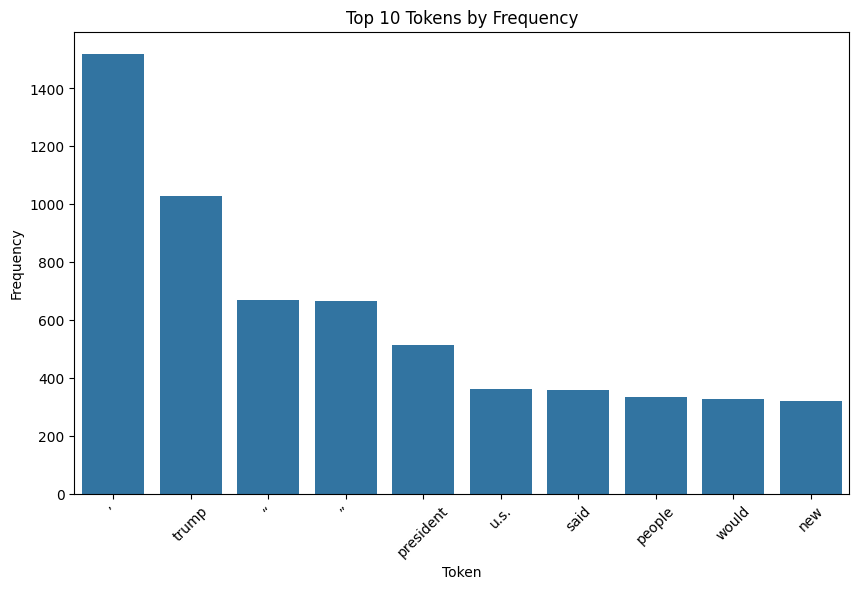

In [39]:
## Your code starts here ##

#flattening the list of all tokens and counting their occurances
all_tokens = [token for sublist in babe_df_cleaned['tokens'] for token in
              sublist]
token_count = Counter(all_tokens)

#plotting the freq od top 10 tokens
top_10_tokens = token_count.most_common(10)

#conv to df for plotting
top_10_df = pd.DataFrame(top_10_tokens, columns=['Token', 'Frequency'])

#plotting
plt.figure(figsize=(10,6))
sns.barplot(x='Token', y='Frequency', data=top_10_df)
plt.title('Top 10 Tokens by Frequency')
plt.xticks(rotation=45)
plt.show()




## end ##

Enter answer here: It's a Zipf distribution.

## (b)

In [40]:
## Your code starts here ##

#top_10_df already contains the req info
print(top_10_df)

## end ##

       Token  Frequency
0          ’       1520
1      trump       1027
2          “        669
3          ”        664
4  president        512
5       u.s.        360
6       said        357
7     people        332
8      would        327
9        new        321


# Q5

## (a)

In [41]:
## Your code starts here ##

#CountVectorizer converts a collection of text docs to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
#to calc mi score
from sklearn.metrics import mutual_info_score

def calc_mi(df, token_column, top_n=500):
  #combining the tokens into strings per row for CountVectorizer
  df['text_combined'] = df[token_column].apply(lambda x: ' '.join(x))

  #creating a CV, considering the top_n most common tokens
  vect = CountVectorizer(max_features=top_n)
  X = vect.fit_transform(df['text_combined'])
  features = vect.get_feature_names_out()

  #getting the topic as y
  y = df['topic'].astype(str)

  #calc mi scores for each feat
  mi_scores = []
  for i in range(X.shape[1]):
    mi_score = mutual_info_score(X[:, i].toarray().ravel(), y)
    mi_scores.append(mi_score)

  #making a df w/ mi scores
  mi_df = pd.DataFrame(list(zip(features, mi_scores)), columns=['Word',
                                                                'MI Score'])

  #creating a df based on mi scores in descending order
  mi_df = mi_df.sort_values(by='MI Score', ascending=False)

  #top 10 tokens thru mi score
  top_tokens = mi_df.head(10)
  return top_tokens

#use the fn to the non-stemmed tokens
mi_df_not_stemmed = calc_mi(babe_df_cleaned, 'tokens')
print(mi_df_not_stemmed)

## end ##

         Word  MI Score
182       gun  0.102106
423       tax  0.073615
443     trump  0.071276
323    police  0.067033
48      black  0.062242
9    abortion  0.061613
78    climate  0.060305
412   student  0.057563
489     women  0.055234
456   vaccine  0.052584


## (b)

In [42]:
## Your code starts here ##

#resusing the fn from 5(a), passing the col for stemmed tokens as arg
mi_df_stemmed = calc_mi(babe_df_cleaned, 'tokens_stemmed')
print(mi_df_stemmed)

## end ##

        Word  MI Score
186      gun  0.114251
465   vaccin  0.098314
431      tax  0.097379
3      abort  0.076426
454    trump  0.071169
343  protest  0.070161
323    polic  0.067433
48     black  0.060222
420  student  0.059489
80    climat  0.057707


## (c)


Enter answer here: It shows the most distinctive words for each topic, demonstrating how specific the tokens are uniquely related with certain topics. The tables from parts a and b show non-stemmed tokens and stemmed tokens, their usage depends on the analytic goal of the user; the one on (a) might offer a more semantic insight, whereas, the one on (b) might offer a more conxise overview of the topic-related words.